## Experiment No. 3 - Implement and test MLP trained with back-propagation algorithm

### Multi-Layer Perceptron with Back-Propagation Algorithm

The Backpropagation neural network is a multilayered, feedforward neural network and is by far the most extensively used. It is also considered one of the simplest and most general methods used for supervised training of multilayered neural networks. Backpropagation works by approximating the non-linear relationship between the input and the output by adjusting the weight values internally. It can further be generalized for the input that is not included in the training patterns (predictive abilities).

## Algorithm

1. Import Library
2. Load csv function
3. MLP
4. Normalize input variable
5. Evaluate

### 1. Import Library

In [1]:
# Backprop on the Seeds Dataset
from random import seed
from random import randrange
from random import random
from csv import reader
from math import exp
from IPython.display import Image

### 2. Load csv function

In [2]:
# Load a CSV file
def load_csv(filename):
    dataset = list()
    with open(filename, 'r') as file:
        csv_reader = reader(file)
        for row in csv_reader:
            if not row:
                continue
            dataset.append(row)
    return dataset

### 3. MLP

In [3]:
# Convert string column to float
def str_column_to_float(dataset, column):
    for row in dataset:
        row[column] = float(row[column].strip())

# Convert string column to integer
def str_column_to_int(dataset, column):
    class_values = [row[column] for row in dataset]
    unique = set(class_values)
    lookup = dict()
    for i, value in enumerate(unique):
        lookup[value] = i
    for row in dataset:
        row[column] = lookup[row[column]]
    return lookup

# Find the min and max values for each column
def dataset_minmax(dataset):
    minmax = list()
    stats = [[min(column), max(column)] for column in zip(*dataset)]
    return stats

# Rescale dataset columns to the range 0-1
def normalize_dataset(dataset, minmax):
    for row in dataset:
        for i in range(len(row)-1):
            row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])

# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / n_folds)
    for i in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
    folds = cross_validation_split(dataset, n_folds)
    scores = list()
    for fold in folds:
        train_set = list(folds)
        train_set.remove(fold)
        train_set = sum(train_set, [])
        test_set = list()
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
        predicted = algorithm(train_set, test_set, *args)
        actual = [row[-1] for row in fold]
        accuracy = accuracy_metric(actual, predicted)
        scores.append(accuracy)
    return scores

# Calculate neuron activation for an input
def activate(weights, inputs):
    activation = weights[-1]
    for i in range(len(weights)-1):
        activation += weights[i] * inputs[i]
    return activation

# Transfer neuron activation
def transfer(activation):
    return 1.0 / (1.0 + exp(-activation))

# Forward propagate input to a network output
def forward_propagate(network, row):
    inputs = row
    for layer in network:
        new_inputs = []
        for neuron in layer:
            activation = activate(neuron['weights'], inputs)
            neuron['output'] = transfer(activation)
            new_inputs.append(neuron['output'])
        inputs = new_inputs
    return inputs

# Calculate the derivative of an neuron output
def transfer_derivative(output):
    return output * (1.0 - output)

# Backpropagate error and store in neurons
def backward_propagate_error(network, expected):
    for i in reversed(range(len(network))):
        layer = network[i]
        errors = list()
        if i != len(network)-1:
            for j in range(len(layer)):
                error = 0.0
                for neuron in network[i + 1]:
                    error += (neuron['weights'][j] * neuron['delta'])
                errors.append(error)
        else:
            for j in range(len(layer)):
                neuron = layer[j]
                errors.append(expected[j] - neuron['output'])
        for j in range(len(layer)):
            neuron = layer[j]
            neuron['delta'] = errors[j] * transfer_derivative(neuron['output'])

# Update network weights with error
def update_weights(network, row, l_rate):
    for i in range(len(network)):
        inputs = row[:-1]
        if i != 0:
            inputs = [neuron['output'] for neuron in network[i - 1]]
        for neuron in network[i]:
            for j in range(len(inputs)):
                neuron['weights'][j] += l_rate * neuron['delta'] * inputs[j]
                neuron['weights'][-1] += l_rate * neuron['delta']

# Train a network for a fixed number of epochs
def train_network(network, train, l_rate, n_epoch, n_outputs):
    for epoch in range(n_epoch):
        for row in train:
            outputs = forward_propagate(network, row)
            expected = [0 for i in range(n_outputs)]
            expected[row[-1]] = 1
            backward_propagate_error(network, expected)
            update_weights(network, row, l_rate)

# Initialize a network
def initialize_network(n_inputs, n_hidden, n_outputs):
    network = list()
    hidden_layer = [{'weights':[random() for i in range(n_inputs + 1)]} for i in range(n_hidden)]
    network.append(hidden_layer)
    output_layer = [{'weights':[random() for i in range(n_hidden + 1)]} for i in range(n_outputs)]
    network.append(output_layer)
    return network

# Make a prediction with a network
def predict(network, row):
    outputs = forward_propagate(network, row)
    return outputs.index(max(outputs))

# Backpropagation Algorithm With Stochastic Gradient Descent
def back_propagation(train, test, l_rate, n_epoch, n_hidden):
    n_inputs = len(train[0]) - 1
    n_outputs = len(set([row[-1] for row in train]))
    network = initialize_network(n_inputs, n_hidden, n_outputs)
    train_network(network, train, l_rate, n_epoch, n_outputs)
    predictions = list()
    for row in test:
        prediction = predict(network, row)
        predictions.append(prediction)
    return(predictions)

### 4. Normalize input variable

In [4]:
# Test Backprop on Seeds dataset
seed(1)
# load and prepare data
filename = 'seeds_dataset.csv'
dataset = load_csv(filename)
for i in range(len(dataset[0])-1):
    str_column_to_float(dataset, i)
# convert class column to integers
str_column_to_int(dataset, len(dataset[0])-1)
# normalize input variables
minmax = dataset_minmax(dataset)
normalize_dataset(dataset, minmax)

### 5. Evaluate 

In [5]:
# evaluate algorithm
n_folds = 5
l_rate = 0.3
n_epoch = 500
n_hidden = 5
scores = evaluate_algorithm(dataset, back_propagation, n_folds, l_rate, n_epoch, n_hidden)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

Scores: [88.09523809523809, 88.09523809523809, 95.23809523809523, 92.85714285714286, 90.47619047619048]
Mean Accuracy: 90.952%


## Questions

**1. What are feed forward Neural Networks? State its advantages.**

Ans:- A feed forward neural network is an artificial neural network where connections between the units do not form a directed cycle. This is different from recurrent neural networks. The feed forward neural network was the first and arguably simplest type of artificial neural network devised. In this network, the information moves in only one direction, forward, (from the input nodes- through the hidden nodes), and to the output nodes. There are no cycles or loops in the network. In a feed forward network information always moves one direction; it never goes backwards. 

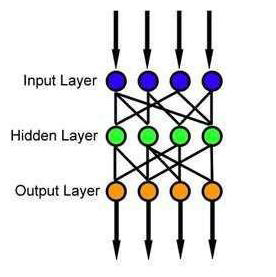

In [6]:
Image("img/fnn.png")

**Advantages**

+ Can be applied to many problems, as long as there is some data.
+ Can be applied to problems, for which analytical methods do not yet exist
+ Can be used to model non-linear dependencies.
+ If there is a pattern, then neural networks should quickly work it out, even if the data is ‘noisy’.
+ Always gives some answer even when the input information is not complete.
+ Networks are easy to maintain.

**2. Explain back propagation algorithm with an example.**

Ans:- Back propagation is a supervised learning method and is a generalization of the delta rule. It requires a dataset of the desired output for many inputs, making up the training set. It is a common method of training artificial neural networks so as to minimize the objective function. The back propagation learning algorithm can be divided into two phases: propagation and weight update. Forward propagation of a training pattern's input through the neural network in order to generate the propagation's output activations. Backward propagation of the propagation's output activations through the neural network using the training pattern's target in order to generate the deltas of all output and hidden neurons.

Algorithm for a 3-layer network: 
1. Initialize the weights in the network (often randomly) 
2. Do 
3. For each example e in the training set 
    + neural-net-output (network, e) ; forward pass
    + T = teacher output for e
    + Calculate error (T - O) at the output units
    + Compute delta_wh for all weights from hidden layer to output layer ; backward pass
    + Compute delta Wi for all weights from input layer to hidden layer ; backward pass
    + Update the weights in the network

4. Until all examples classified correctly or stopping criterion satisfied. 


**3. Repeat the problem theoretically for one iteration and determine the values of weights.**

Ans:- We’ll explain the backpropagation process in the abstract, with very simple math. To understand the mathematics behind backpropagation.

The image above is a very simple neural network model with two inputs (i1 and i2), which can be real values between 0 and 1, two hidden neurons (h1 and h2), and two output neurons (o1 and o2).

The model also has two biases
Biases in neural networks are extra neurons added to each layer, which store the value of 1. This allows you to “move” or translate the activation function so it doesn’t cross the origin, by adding a constant number.

Without a bias neuron, each neuron can only take the input and multiply it by a weight. So, for example, it would not be possible to input a value of 0 and output 2. In many cases, it is necessary to move the entire activation function to the left or right to generate the required output values – this is made possible by the bias.

What the neurons do
Remember—each neuron is a very simple component which does nothing but executes the activation function. There are several commonly used activation functions; for example, this is the sigmoid function:

$$f(x) = 1 / 1 + exp(-x)$$

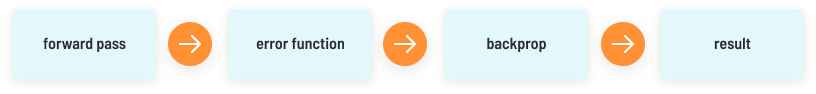

In [7]:
Image("img/img.png")

**The forward pass**
Our simple neural network works by:

+ Taking each of the two inputs
+ Multiplying by the first-layer weights—w1,2,3,4
+ Adding bias
+ Applying the activation function for neurons h1 and h2
+ Taking the output of h1 and h2, multiplying by the second layer weights—w5,6,7,8
+ This is the output.

To take a concrete example, say the first input i1 is 0.1, the weight going into the first neuron, w1, is 0.27, the second input i2 is 0.2, the weight from the second weight to the first neuron, w3, is 0.57, and the first layer bias b1 is 0.4.

The input of the first neuron h1 is combined from the two inputs, i1 and i2:

$$(i1 * w1) + (i2 * w2) + b1 = (0.1 * 0.27) + (0.2 * 0.57) + (0.4 * 1) = 0.541$$

Feeding this into the activation function of neuron h1:

$$f(0.541) = 1 / (1 + exp(-0.541)) = 0.632$$

Now, given some other weights w2 and w4 and the second input i2, you can follow a similar calculation to get an output for the second neuron in the hidden layer, h2.

The final step is to take the outputs of neurons h1 and h2, multiply them by the weights w5,6,7,8, and feed them to the same activation function of neurons o1 and o2 (exactly the same calculation as above).

The result is the final output of the neural network—let’s say the final outputs are 0.735 for o1 and 0.455 for o2.

We’ll also assume that the correct output values are 0.5 for o1 and 0.5 for o2 (these are assumed correct values because in supervised learning, each data point had its truth value).

The error function
The error function For simplicity, we’ll use the Mean Squared Error function. For the first output, the error is the correct output value minus the actual output of the neural network:

$0.5—0.735 = -0.235$

For the second output:

$0.5—0.455 = 0.045$

Now we’ll calculate the Mean Squared Error:

$$MSE(o1) = ½ (-0.235)2 = 0.0276$$

$$MSE(o2) = ½ (0.045)2 = 0.001$$

The Total Error is the sum of the two errors:

$$Total Error = 0.0276 + 0.001 = 0.0286$$

This is the number we need to minimize with backpropagation.

Backpropagation with gradient descent
The backpropagation algorithm calculates how much the final output values, o1 and o2, are affected by each of the weights. To do this, it calculates partial derivatives, going back from the error function to the neuron that carried a specific weight.

For example, weight w6, going from hidden neuron h1 to output neuron o2, affected our model as follows:

neuron h1 with weight w6 → affects total input of neuron o2 → affects output o2 → affects total errors
Backpropagation goes in the opposite direction:

total errors → affected by output o2 → affected by total input of neuron o2 → affected by neuron h1 with weight w6 The algorithm calculates three derivatives:
The algorithm calculates three derivatives:

The derivative of total errors with respect to output o2
The derivative of output o2 with respect to total input of neuron o2
Total input of neuron o2 with respect to neuron h1 with weight w6
This gives us complete traceability from the total errors, all the way back to the weight w6.

Using the Leibniz Chain Rule, it is possible to calculate, based on the above three derivatives, what is the optimal value of w6 that minimizes the error function. In other words, what is the “best” weight w6 that will make the neural network most accurate?

Similarly, the algorithm calculates an optimal value for each of the 8 weights. Or, in a realistic model, for each of thousands or millions of weights used for all neurons in the model.

End result of backpropagation
The backpropagation algorithm results in a set of optimal weights, like this:

Optimal w1 = 0.355 

Optimal w2 = 0.476 

Optimal w3 = 0.233 

Optimal w4 = 0.674 

Optimal w5 = 0.142 

Optimal w6 = 0.967 

Optimal w7 = 0.319 

Optimal w8 = 0.658
You can update the weights to these values, and start using the neural network to make predictions for new inputs.

**4. State activation function used in BPN. What is its significance?**

Ans:- Activation function decides, whether a neuron should be activated or not by calculating weighted sum and further adding bias with it. The purpose of the activation function is to introduce non-linearity into the output of a neuron.

We know, neural network has neurons that work in correspondence of weight, bias and their respective activation function. In a neural network, we would update the weights and biases of the neurons on the basis of the error at the output. This process is known as back-propagation. Activation functions make the back-propagation possible since the gradients are supplied along with the error to update the weights and biases.

**Why do we need Non-linear activation functions**:-
A neural network without an activation function is essentially just a linear regression model. The activation function does the non-linear transformation to the input making it capable to learn and perform more complex tasks.  Neuron can not learn with just a linear function attached to it. A non-linear activation function will let it learn as per the difference w.r.t error. Hence we need activation function.

**VARIANTS OF ACTIVATION FUNCTION**:-

1. **Linear Function**:-

    + Equation : Linear function has the equation similar to as of a straight line i.e. y = ax
    + No matter how many layers we have, if all are linear in nature, the final activation function of last layer is nothing but just a linear function of the input of first layer.
    + Range : -inf to +inf
    + Uses : Linear activation function is used at just one place i.e. output layer.
    + Issues : If we will differentiate linear function to bring non-linearity, result will no more depend on input “x” and function will become constant, it won’t introduce any ground-breaking behavior to our algorithm.

For example : Calculation of price of a house is a regression problem. House price may have any big/small value, so we can apply linear activation at output layer. Even in this case neural net must have any non-linear function at hidden layers.

2. **Sigmoid Function**:-

    + It is a function which is plotted as ‘S’ shaped graph.
    + Equation :
    $$A = 1/(1 + e-x)$$
    + Nature : Non-linear. Notice that X values lies between -2 to 2, Y values are very steep. This means, small changes in x would also bring about large changes in the value of Y.
    + Value Range : 0 to 1
    + Uses : Usually used in output layer of a binary classification, where result is either 0 or 1, as value for sigmoid function lies between 0 and 1 only so, result can be predicted easily to be 1 if value is greater than 0.5 and 0 otherwise.

3. **Tanh Function**:- The activation that works almost always better than sigmoid function is Tanh function also knows as Tangent Hyperbolic function. It’s actually mathematically shifted version of the sigmoid function. Both are similar and can be derived from each other.

    + Equation :-
$$f(x) = tanh(x) = 2/(1 + e-2x) - 1$$
$$OR$$
$$tanh(x) = 2 * sigmoid(2x) - 1 $$
    + Value Range :- -1 to +1
    + Nature :- non-linear
    + Uses :- Usually used in hidden layers of a neural network as it’s values lies between -1 to 1 hence the mean for the hidden layer comes out be 0 or very close to it, hence helps in centering the data by bringing mean close to 0. This makes learning for the next layer much easier.

4. **RELU**:- Stands for Rectified linear unit. It is the most widely used activation function. Chiefly implemented in hidden layers of Neural network.

    + Equation :- A(x) = max(0,x). It gives an output x if x is positive and 0 otherwise.
    + Value Range :- [0, inf]
    + Nature :- non-linear, which means we can easily backpropagate the errors and have multiple layers of neurons being activated by the ReLU function.
    + Uses :- ReLu is less computationally expensive than tanh and sigmoid because it involves simpler mathematical operations. At a time only a few neurons are activated making the network sparse making it efficient and easy for computation.
    
In simple words, RELU learns much faster than sigmoid and Tanh function.

5. **Softmax Function**:- The softmax function is also a type of sigmoid function but is handy when we are trying to handle classification problems.

    + Nature :- non-linear
    + Uses :- Usually used when trying to handle multiple classes. The softmax function would squeeze the outputs for each class between 0 and 1 and would also divide by the sum of the outputs.
    + Output:- The softmax function is ideally used in the output layer of the classifier where we are actually trying to attain the probabilities to define the class of each input.

**CHOOSING THE RIGHT ACTIVATION FUNCTION**

The basic rule of thumb is if you really don’t know what activation function to use, then simply use RELU as it is a general activation function and is used in most cases these days.
If your output is for binary classification then, sigmoid function is very natural choice for output layer.

Foot Note :-
The activation function does the non-linear transformation to the input making it capable to learn and perform more complex tasks.



**5. State advantages, disadvantages & applications of BPN algorithm.**

Ans:- 

**Advantages**

+ It is fast, simple and easy to program.
+ It has no parameters to tune (except for the number of input).
+ This is a shift in mind set for the learning-system designer instead of trying to design a learning algorithm that is accurate over the entire space
+ The backpropagation algorithm is more accurate and cheaper than estimating gradients numerically.
+ Backpropagation computes the gradient of the loss function with respect to the weights of the network for a single input–output example, and does so efficiently, unlike a naive direct computation of the gradient with respect to each weight individually.

**Disadvantages**

+ The actual performance of Backpropagation on a particular problem is clearly dependent on the input data. 
+ Backpropagation can be quite sensitive to noisy data
+ You need to use the matrix-based approach for backpropagation instead of mini-batch.
+ Gradient descent with backpropagation is not guaranteed to find the global minimum of the error function, but only a local minimum; also, it has trouble crossing plateaus in the error function landscape. This issue, caused by the non-convexity of error functions in neural networks, was long thought to be a major drawback, but Yann LeCun et al. argue that in many practical problems, it is not. 
+ Backpropagation learning does not require normalization of input vectors; however, normalization could improve performance. 
+ Backpropagation requires the derivatives of activation functions to be known at network design time.

**Applications**

+ Mapping character strings into phonemes so they can be pronounced by a computer

+ Neural network trained how to pronounce each letter in a word in a sentence, given the three letters before and three letters after in a window

+ In the field of Speech Recognition

+ In the field of Character Recognition

+ In the field of Face Recognition

### References

[1] https://machinelearningmastery.com/implement-backpropagation-algorithm-scratch-python/

[2] (a) https://pythonmachinelearning.pro/complete-guide-to-deep-neural-networks-part-1/

[2] (b) https://pythonmachinelearning.pro/complete-guide-to-deep-neural-networks-part-2/

[3] https://medium.com/@tiago.tmleite/neural-networks-multilayer-perceptron-and-the-backpropagation-algorithm-a5cd5b904fde

[4] https://www.kaggle.com/ancientaxe/simple-neural-network-from-scratch-in-python

Author Name:- Hemant Ghuge <br/>
LinkedIn:- https://www.linkedin.com/in/hemantghuge/ <br/>
GitHub:- https://github.com/HemantGorakshGhuge <br/>